In [1]:
import sys
sys.path.append('..')

In [2]:
import os
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
from tqdm import tqdm
from dataclasses import dataclass
from matplotlib import pyplot as plt
from timeit import default_timer as timer
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from typing import List, Dict
from CommonFunctions import *
%matplotlib inline

In [3]:
@dataclass
class LearningParameters:
    batch_size: int = 128
    cpu_count: int = os.cpu_count()
    learning_rate: float = 0.05
    momentum: float = 0.9
    weight_decay: float = 0.001
    epochs: int = 150
    device: torch.device = torch.device(
        'cuda' if torch.cuda.is_available() else 'cpu')
    dropout: float = 0.3
    batch_norm: bool = True
PARAMS = LearningParameters()

def load_dataset(path, transform, subset=None, download=False):
    train_data = datasets.CIFAR10(root=path, 
                                  train=True, 
                                  download=download, 
                                  transform=transform)
    test_data = datasets.CIFAR10(root=path, 
                                 train=False,
                                 download=download, 
                                 transform=transform)
    if subset is not None:
        train_data = Subset(train_data, range(subset[0]))
        test_data = Subset(test_data, range(subset[1]))
    train_dataloader = DataLoader(dataset=train_data, 
                                  batch_size=PARAMS.batch_size,
                                  shuffle=True,
                                  pin_memory=True)
    test_dataloader = DataLoader(dataset=test_data,
                                 batch_size=PARAMS.batch_size,
                                 shuffle=False,
                                 pin_memory=True)
    return train_data, test_data, train_dataloader, test_dataloader


class ModularVGG(nn.Module):
    """
    VGG model that can be arbitrarily modified
    """
    def __init__(self, input_layer_size: int, num_of_classes: int, image_size: int, config: Dict):
        super(ModularVGG, self).__init__()
        self.latest_layer_size = input_layer_size
        self.image_size = image_size
        
        self.conv_layer = nn.Sequential(
            *self._conv_layers(**config['CONV']),
            nn.Flatten()
        )
        
        self.classifier = nn.Sequential(
            *self._linear_layers(**config['FC']),
            nn.Linear(in_features=self.latest_layer_size,
                      out_features=num_of_classes),
            nn.Softmax(dim=1)
        )
        
        self.initialize_weights()
        
    def _conv_layers(self, conv_layers: List[List[int]],
                           kernel_params: Dict,
                           batch_norm: bool = False,
                           activation: nn.Module = nn.ReLU(inplace=True)) -> List[nn.Module]:
        layers = []
        for conv_layer in conv_layers:
            for out_channels in conv_layer:
                layers += [nn.Conv2d(in_channels=self.latest_layer_size,
                                     out_channels=out_channels, **kernel_params), activation]
                self.latest_layer_size = out_channels
            layers += [nn.MaxPool2d(kernel_size=2)]
            layers += [nn.BatchNorm2d(num_features=self.latest_layer_size)] if batch_norm else []
        self.latest_layer_size = (self.image_size // 2**len(conv_layers))**2 * self.latest_layer_size
        return layers
                
    
    def _linear_layers(self, layer_sizes: List[int],
                             dropout: float = 0.,
                             activation: nn.Module = nn.ReLU(inplace=True)) -> List[nn.Module]:
        layers = []
        for layer_size in layer_sizes:
            layers += [nn.Dropout(p=dropout)] if dropout > 0 else []
            layers += [nn.Linear(in_features=self.latest_layer_size,
                                 out_features=layer_size), activation]
            self.latest_layer_size = layer_size
        return layers
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
                m.bias.data.zero_()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(self.conv_layer(x))

def accuracy(y_pred, y_true):
    return (y_true == y_pred).sum().item() / len(y_pred)

def train_step(model, dataloader, criterion, accuracy_function, optimizer, device):
    train_loss, accuracy = 0, 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = criterion(y_pred, y)
        train_loss += loss.item()
        accuracy += accuracy_function(y_pred.argmax(dim=1), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= (data_len := len(dataloader))
    accuracy /= data_len
    return train_loss, accuracy

def test_step(model, dataloader, criterion, accuracy_function, device):
    test_loss, accuracy = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            loss = criterion(test_pred, y)
            test_loss += loss.item()
            accuracy += accuracy_function(test_pred.argmax(dim=1), y)
        test_loss /= (data_len := len(dataloader))
        accuracy /= data_len
    return test_loss, accuracy

def plot_loss_and_accuracy(title, epochs, loss_dict, accuracy_dict, file):
    with plt.style.context('cyberpunk'):
        figure, axes = plt.subplots(2, 1, layout='constrained', figsize=(8, 6))
        x_axis = range(1, epochs + 1)
        for loss_type, loss in loss_dict.items():
            axes[0].plot(x_axis, loss, label=f'{loss_type}: {min(loss):.3f}')
        axes[0].set(ylabel='Loss', title=title)
        axes[0].legend()
        enhance_plot(figure, axes[0], glow=True)
        for accuracy_type, accuracy in accuracy_dict.items():
            axes[1].plot(x_axis, accuracy, label=f'{accuracy_type}: {max(accuracy):.3f}')
        axes[1].set(ylabel='Accuracy')
        axes[1].legend()
        enhance_plot(figure, axes[1], glow=True)
    figure.savefig(f'images/{file}.png')
    return figure, axes

In [4]:
class ResidualBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(ResidualBlock, self).__init__()

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        self.residual_block = nn.Sequential(
            nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(planes), nn.ReLU(),
            nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False), 
            nn.BatchNorm2d(planes)
        )
        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activation(self.residual_block(x) + self.shortcut(x))

class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        activation = nn.ReLU()
        layer1 = self._make_layer(ResidualBlock, 64, num_blocks[0], stride=1)
        layer2 = self._make_layer(ResidualBlock, 128, num_blocks[1], stride=2)
        layer3 = self._make_layer(ResidualBlock, 256, num_blocks[2], stride=2)
        layer4 = self._make_layer(ResidualBlock, 512, num_blocks[3], stride=2)
        
        self.resnet_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64), activation,
            layer1, layer2, layer3, layer4,
            nn.AvgPool2d(kernel_size=4)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * ResidualBlock.expansion, num_classes),
            nn.Softmax(dim=1)
        )

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(self.resnet_layers(x))

def ResNet18():
    return ResNet([2, 2, 2, 2])

def ResNet34():
    return ResNet([3, 4, 6, 3])

def ResNet18Transfered():
    weights = models.ResNet18_Weights.DEFAULT
    model = models.resnet18(weights=weights)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    model.relu = nn.Identity()
    model.maxpool = nn.Identity() 
    model.fc = nn.Linear(in_features=512, out_features=10)
    return model

KERNEL_PARAMS = dict(kernel_size=3, stride=1, padding=1)

def VGG13():
    model_config = dict(
        CONV=dict(
            conv_layers=[[64, 64],
                         [128, 128],
                         [256, 256],
                         [512, 512],
                         [512, 512]],
            kernel_params=KERNEL_PARAMS,
            batch_norm=PARAMS.batch_norm
        ),
        FC=dict(
            layer_sizes=[4096, 4096, 1000],
            dropout=PARAMS.dropout
        )
    )
    return ModularVGG(input_layer_size=3,
                      num_of_classes=10,
                      image_size=32,
                      config=model_config)
    

def VGG22():
    model_config = dict(
        CONV=dict(
            conv_layers=[[64, 64],
                         [128, 128],
                         [256, 256, 256, 256, 256],
                         [512, 512, 512, 512, 512],
                         [512, 512, 512, 512, 512]],
            kernel_params=KERNEL_PARAMS,
            batch_norm=PARAMS.batch_norm
        ),
        FC=dict(
            layer_sizes=[4096, 4096, 1000],
            dropout=PARAMS.dropout
        )
    ) 
    return ModularVGG(input_layer_size=3,
                      num_of_classes=10,
                      image_size=32,
                      config=model_config)

In [5]:
transform_normalized = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

cnn_models = {
    'VGG13': VGG13(),
    'VGG22': VGG22(),
    'ResNet18': ResNet18(),
    'ResNet34': ResNet34(),
    'ResNet18 TL': ResNet18Transfered()
}

In [6]:
data_path = Path('./data')
loss_dict = {}
acc_dict = {}
_, _, train_dataloader, test_dataloader = load_dataset(
    data_path, transform_normalized, (8000, 2000))

for model_name, model in cnn_models.items():
    print(model_name)
    model.to(PARAMS.device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), 
                                lr=PARAMS.learning_rate,
                                momentum=PARAMS.momentum)
    train_time_start = timer()
    train_loss = []
    test_acc = []
    for epoch in tqdm(range(PARAMS.epochs)):
        train_metrics = train_step(
            model, train_dataloader, loss_fn, accuracy, optimizer, PARAMS.device)
        test_metrics = test_step(
            model, test_dataloader, loss_fn, accuracy, PARAMS.device)
        train_loss.append(train_metrics[0])
        test_acc.append(test_metrics[1])
    loss_dict[model_name] = train_loss
    acc_dict[model_name] = test_acc
    train_time = timer() - train_time_start
    print(f'Time: {train_time:.3f} seconds')

VGG13


100%|██████████| 150/150 [08:35<00:00,  3.43s/it]


Time: 515.030 seconds
VGG22


100%|██████████| 150/150 [11:23<00:00,  4.56s/it]


Time: 683.328 seconds
ResNet18


100%|██████████| 150/150 [14:25<00:00,  5.77s/it]


Time: 865.922 seconds
ResNet34


100%|██████████| 150/150 [23:35<00:00,  9.44s/it]


Time: 1415.835 seconds
ResNet18 TL


100%|██████████| 150/150 [14:03<00:00,  5.63s/it]

Time: 843.917 seconds


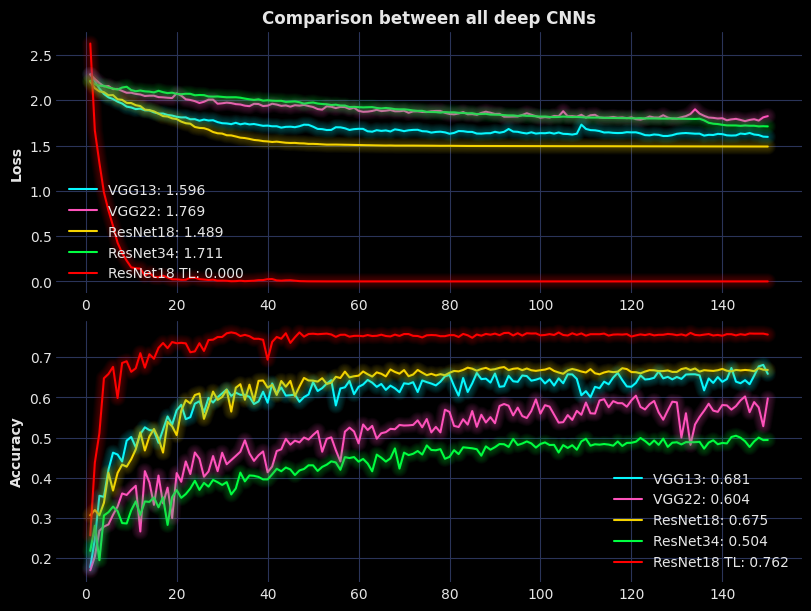

In [8]:
title = 'Comparison between all deep CNNs'
plot_loss_and_accuracy(title, PARAMS.epochs, loss_dict, acc_dict, 'AllCNNComparison');